**Importing Libraries needed**

In [3]:
from google.colab import drive
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt


#**Dataset Reading**

**Reading the dataset from google drive**

In [4]:
import os
import cv2

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Prompt the user to input the dataset path
dataset_path = input("Enter the path to the dataset: ")

# Function to load images from the dataset
def load_dataset(dataset_path):
    data = []
    labels = []
    for user_folder in os.listdir(dataset_path):
        user_path = os.path.join(dataset_path, user_folder)
        if os.path.isdir(user_path):  # Check if it's a directory
            for image_file in os.listdir(user_path):
                image_path = os.path.join(user_path, image_file)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    data.append(image)
                    labels.append(user_folder)  # Use folder name as label
    return data, labels

# Load the dataset
try:
    images, labels = load_dataset(dataset_path)
    print(f"Loaded {len(images)} images from the dataset.")
except Exception as e:
    print(f"Error loading dataset: {e}")


Mounted at /content/drive
Loaded 4478 images from the dataset.


**Displaying the first and last 5 images in the dataset to make sure everything is alright**

									First 5 images:


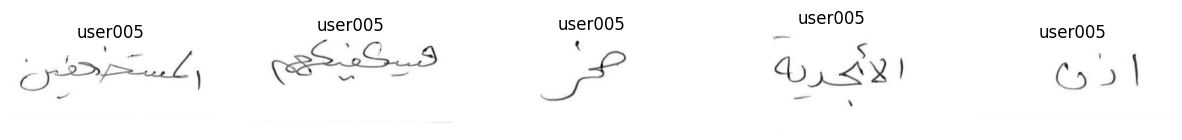

									Last 5 images:


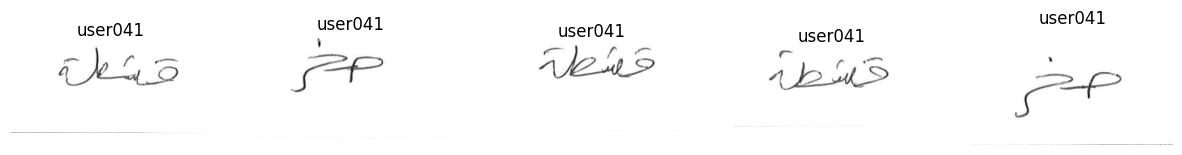

In [3]:
# Show some example images
def show_example_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()

# Display the first 5 images and their labels
print("\t\t\t\t\t\t\t\t\tFirst 5 images:")
show_example_images(images, labels, num_images=5)

# Show last 5 images
def show_last_example_images(images, labels, num_images=5):
    # Get the last 'num_images' images and labels using slicing
    images_to_show = images[-num_images:]
    labels_to_show = labels[-num_images:]

    # Plot the images
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images_to_show[i], cmap='gray')
        plt.title(labels_to_show[i])
        plt.axis('off')
    plt.show()

# Display the last 5 images and their labels
print("\t\t\t\t\t\t\t\t\tLast 5 images:")
show_last_example_images(images, labels, num_images=5)

In [4]:
# Print the size of the first image in the dataset
print(f"Size of the first image: {images[26].shape}")

Size of the first image: (128, 182)


#**Data Preprocessing**

**Data Preprocessing:**
- **Resize all images to a common size.**
- **Normalize pixel values.**
- **Apply histogram equalization to handle illumination differences.**

In [5]:
def preprocess_image(image, size=(128, 128)):
    resized_image = cv2.resize(image, size)
    normalized_image = cv2.normalize(resized_image, None, 0, 255, cv2.NORM_MINMAX)
    # Apply histogram equalization
    equalized_image = cv2.equalizeHist(normalized_image)
    # Denoise using Gaussian blur
    denoised_image = cv2.GaussianBlur(equalized_image, (5, 5), 0)
    return denoised_image



# Preprocess all images
preprocessed_images = [preprocess_image(img) for img in images]


In [6]:
# Print the size of the first image in the dataset
print(f"Size of the first image: {preprocessed_images[26].shape}")

Size of the first image: (128, 128)


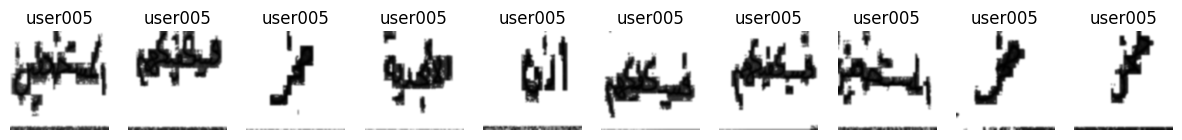

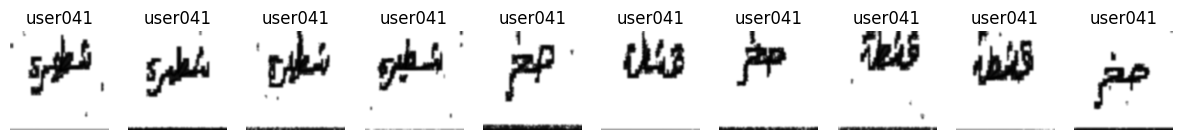

In [7]:
show_example_images(preprocessed_images, labels, num_images=10)
show_last_example_images(preprocessed_images, labels, num_images=10)

# **Trying Different Approaches and** ***Before Applying Robustness Test***

In [12]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
import cv2
import time

# Assume preprocessed_images (list of preprocessed images) and labels (corresponding labels) are available

# Step 1: Encode labels
print("\n" + "-" * 50)
print("Step 1: Encoding Labels")
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Step 2: Split data into training and testing sets
print("\n" + "-" * 50)
print("Step 2: Splitting Data")
train_images, test_images, train_labels, test_labels = train_test_split(
    preprocessed_images, encoded_labels, test_size=0.2, random_state=42
)
print(f"Training samples: {len(train_images)}, Testing samples: {len(test_images)}")

# Step 3: Feature extraction
print("\n" + "-" * 50)
print("Step 3: Feature Extraction")

def extract_features(images, method='sift'):
    if method == 'sift':
        detector = cv2.SIFT_create()
    elif method == 'orb':
        detector = cv2.ORB_create()
    else:
        raise ValueError("Unsupported method. Use 'sift' or 'orb'.")

    descriptors_list = []
    start_time = time.time()
    for image in images:
        keypoints, descriptors = detector.detectAndCompute(image, None)
        descriptors_list.append(descriptors if descriptors is not None else np.array([]))
    end_time = time.time()
    print(f"[Feature Extraction] {method.upper()} extraction time: {end_time - start_time:.2f} seconds")
    return descriptors_list

# Extract descriptors for training and testing sets
train_sift_descriptors = extract_features(train_images, method='sift')
test_sift_descriptors = extract_features(test_images, method='sift')

train_orb_descriptors = extract_features(train_images, method='orb')
test_orb_descriptors = extract_features(test_images, method='orb')

# Step 4a: Clustering for VBOW
print("\n" + "-" * 50)
print("Step 4a: Clustering for VBOW")

def concatenate_descriptors(descriptors_list):
    return np.vstack([desc for desc in descriptors_list if desc.size > 0])

all_train_sift_descriptors = concatenate_descriptors(train_sift_descriptors)
all_train_orb_descriptors = concatenate_descriptors(train_orb_descriptors)

def cluster_descriptors(descriptors, num_clusters=500):
    start_time = time.time()
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(descriptors)
    end_time = time.time()
    print(f"[Clustering] VBOW clustering time: {end_time - start_time:.2f} seconds")
    return kmeans

sift_kmeans = cluster_descriptors(all_train_sift_descriptors, num_clusters=1000)
orb_kmeans = cluster_descriptors(all_train_orb_descriptors, num_clusters=1000)

def compute_vbow(descriptors_list, kmeans):
    start_time = time.time()
    histograms = []
    for descriptors in descriptors_list:
        if descriptors.size > 0:
            cluster_indices = kmeans.predict(descriptors)
            histogram, _ = np.histogram(cluster_indices, bins=np.arange(kmeans.n_clusters + 1))
            histograms.append(histogram)
        else:
            histograms.append(np.zeros(kmeans.n_clusters))
    end_time = time.time()
    print(f"[VBOW Computation] VBOW histogram computation time: {end_time - start_time:.2f} seconds")
    return np.array(histograms)

train_sift_vbow = compute_vbow(train_sift_descriptors, sift_kmeans)
test_sift_vbow = compute_vbow(test_sift_descriptors, sift_kmeans)

train_orb_vbow = compute_vbow(train_orb_descriptors, orb_kmeans)
test_orb_vbow = compute_vbow(test_orb_descriptors, orb_kmeans)

# Step 4b: KNN for feature matching
print("\n" + "-" * 50)
print("Step 4b: KNN for Feature Matching")
start_time = time.time()
sift_knn = NearestNeighbors(n_neighbors=3, algorithm='auto')
sift_knn.fit(all_train_sift_descriptors)
end_time = time.time()
print(f"[KNN Matching] SIFT KNN training time: {end_time - start_time:.2f} seconds")

start_time = time.time()
orb_knn = NearestNeighbors(n_neighbors=3, algorithm='auto')
orb_knn.fit(all_train_orb_descriptors)
end_time = time.time()
print(f"[KNN Matching] ORB KNN training time: {end_time - start_time:.2f} seconds")

def generate_feature_vectors(test_descriptors, knn, descriptor_to_label):
    feature_vectors = []
    start_time = time.time()
    for descriptors in test_descriptors:
        if descriptors.size > 0:
            distances, indices = knn.kneighbors(descriptors)
            match_counts = np.zeros(len(np.unique(descriptor_to_label)))
            for idx in indices:
                matching_labels = descriptor_to_label[idx]
                for label in matching_labels:
                    match_counts[label] += 1
            feature_vectors.append(match_counts)
        else:
            feature_vectors.append(np.zeros(len(np.unique(descriptor_to_label))))
    end_time = time.time()
    print(f"[KNN Feature Vector Generation] Time: {end_time - start_time:.2f} seconds")
    return np.array(feature_vectors)

def create_descriptor_to_label_map(descriptors_list, labels):
    descriptor_to_label = []
    for img_idx, descriptors in enumerate(descriptors_list):
        if descriptors.size > 0:
            descriptor_to_label.extend([labels[img_idx]] * len(descriptors))
    return np.array(descriptor_to_label)

sift_descriptor_to_label = create_descriptor_to_label_map(train_sift_descriptors, train_labels)
orb_descriptor_to_label = create_descriptor_to_label_map(train_orb_descriptors, train_labels)

train_sift_feature_vectors = generate_feature_vectors(train_sift_descriptors, sift_knn, sift_descriptor_to_label)
test_sift_feature_vectors = generate_feature_vectors(test_sift_descriptors, sift_knn, sift_descriptor_to_label)

train_orb_feature_vectors = generate_feature_vectors(train_orb_descriptors, orb_knn, orb_descriptor_to_label)
test_orb_feature_vectors = generate_feature_vectors(test_orb_descriptors, orb_knn, orb_descriptor_to_label)

# Step 5a: Train and evaluate SVM with VBOW
print("\n" + "-" * 50)
print("Step 5a: Training and Evaluating SVM with VBOW")

# SIFT VBOW
print("\n[SVM with SIFT VBOW]")
start_time = time.time()
svm_sift_vbow = SVC(kernel='linear', random_state=42)
svm_sift_vbow.fit(train_sift_vbow, train_labels)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

start_time = time.time()
predictions_sift_vbow = svm_sift_vbow.predict(test_sift_vbow)
end_time = time.time()
print(f"Prediction time: {end_time - start_time:.2f} seconds")

accuracy_sift_vbow = accuracy_score(test_labels, predictions_sift_vbow) * 100
print(f"Accuracy: {accuracy_sift_vbow:.2f}%")

# ORB VBOW
print("\n[SVM with ORB VBOW]")
start_time = time.time()
svm_orb_vbow = SVC(kernel='linear', random_state=42)
svm_orb_vbow.fit(train_orb_vbow, train_labels)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

start_time = time.time()
predictions_orb_vbow = svm_orb_vbow.predict(test_orb_vbow)
end_time = time.time()
print(f"Prediction time: {end_time - start_time:.2f} seconds")

accuracy_orb_vbow = accuracy_score(test_labels, predictions_orb_vbow) * 100
print(f"Accuracy: {accuracy_orb_vbow:.2f}%")

# Step 5b: Train and evaluate SVM with KNN-based features
print("\n" + "-" * 50)
print("Step 5b: Training and Evaluating SVM with KNN-based Features")

# SIFT KNN
print("\n[SVM with SIFT KNN]")
start_time = time.time()
svm_sift_knn = SVC(kernel='linear', random_state=42)
svm_sift_knn.fit(train_sift_feature_vectors, train_labels)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

start_time = time.time()
predictions_sift_knn = svm_sift_knn.predict(test_sift_feature_vectors)
end_time = time.time()
print(f"Prediction time: {end_time - start_time:.2f} seconds")

accuracy_sift_knn = accuracy_score(test_labels, predictions_sift_knn) * 100
print(f"Accuracy: {accuracy_sift_knn:.2f}%")

# ORB KNN
print("\n[SVM with ORB KNN]")
start_time = time.time()
svm_orb_knn = SVC(kernel='linear', random_state=42)
svm_orb_knn.fit(train_orb_feature_vectors, train_labels)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

start_time = time.time()
predictions_orb_knn = svm_orb_knn.predict(test_orb_feature_vectors)
end_time = time.time()
print(f"Prediction time: {end_time - start_time:.2f} seconds")

accuracy_orb_knn = accuracy_score(test_labels, predictions_orb_knn) * 100
print(f"Accuracy: {accuracy_orb_knn:.2f}%")

# Summary
print("\n" + "-" * 50)
print("[Summary of Results]")
print(f"SIFT VBOW Accuracy: {accuracy_sift_vbow:.2f}%")
print(f"ORB VBOW Accuracy: {accuracy_orb_vbow:.2f}%")
print(f"SIFT KNN Accuracy: {accuracy_sift_knn:.2f}%")
print(f"ORB KNN Accuracy: {accuracy_orb_knn:.2f}%")


--------------------------------------------------
Step 1: Encoding Labels

--------------------------------------------------
Step 2: Splitting Data
Training samples: 3582, Testing samples: 896

--------------------------------------------------
Step 3: Feature Extraction
[Feature Extraction] SIFT extraction time: 33.59 seconds
[Feature Extraction] SIFT extraction time: 9.68 seconds
[Feature Extraction] ORB extraction time: 4.43 seconds
[Feature Extraction] ORB extraction time: 1.10 seconds

--------------------------------------------------
Step 4a: Clustering for VBOW
[Clustering] VBOW clustering time: 626.45 seconds
[Clustering] VBOW clustering time: 619.73 seconds
[VBOW Computation] VBOW histogram computation time: 5.48 seconds
[VBOW Computation] VBOW histogram computation time: 1.12 seconds
[VBOW Computation] VBOW histogram computation time: 3.83 seconds
[VBOW Computation] VBOW histogram computation time: 0.96 seconds

--------------------------------------------------
Step 4b: 

AttributeError: 'SVC' object has no attribute 'fit_time'

# **The Final Code with Applying Robustness**

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
import cv2
import time

# Step 1: Encode labels
print("\n" + "-" * 50)
print("Step 1: Encoding Labels")
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Step 2: Split data into training and testing sets
print("\n" + "-" * 50)
print("Step 2: Splitting Data")
train_images, test_images, train_labels, test_labels = train_test_split(
    preprocessed_images, encoded_labels, test_size=0.2, random_state=42
)
print(f"Training samples: {len(train_images)}, Testing samples: {len(test_images)}")

# Step 3: Feature extraction
print("\n" + "-" * 50)
print("Step 3: Feature Extraction")

def extract_features(images, method='sift'):
    if method == 'sift':
        detector = cv2.SIFT_create()
    elif method == 'orb':
        detector = cv2.ORB_create()
    else:
        raise ValueError("Unsupported method. Use 'sift' or 'orb'.")

    descriptors_list = []
    keypoint_counts = []
    start_time = time.time()
    for image in images:
        keypoints, descriptors = detector.detectAndCompute(image, None)
        keypoint_counts.append(len(keypoints))
        descriptors_list.append(descriptors if descriptors is not None else np.array([]))
    end_time = time.time()
    print(f"[Feature Extraction] {method.upper()} extraction time: {end_time - start_time:.2f} seconds")
    print(f"[Keypoint Detection] {method.upper()} average keypoints: {np.mean(keypoint_counts):.2f}")
    return descriptors_list

train_sift_descriptors = extract_features(train_images, method='sift')
test_sift_descriptors = extract_features(test_images, method='sift')

train_orb_descriptors = extract_features(train_images, method='orb')
test_orb_descriptors = extract_features(test_images, method='orb')

# Step 4a: Clustering for VBOW
print("\n" + "-" * 50)
print("Step 4a: Clustering for VBOW")

def concatenate_descriptors(descriptors_list):
    return np.vstack([desc for desc in descriptors_list if desc.size > 0])

all_train_orb_descriptors = concatenate_descriptors(train_orb_descriptors)

def cluster_descriptors(descriptors, num_clusters=500):
    start_time = time.time()
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(descriptors)
    end_time = time.time()
    print(f"[Clustering] VBOW clustering time: {end_time - start_time:.2f} seconds")
    return kmeans

orb_kmeans = cluster_descriptors(all_train_orb_descriptors, num_clusters=1000)

def compute_vbow(descriptors_list, kmeans):
    start_time = time.time()
    histograms = []
    for descriptors in descriptors_list:
        if descriptors.size > 0:
            cluster_indices = kmeans.predict(descriptors)
            histogram, _ = np.histogram(cluster_indices, bins=np.arange(kmeans.n_clusters + 1))
            histograms.append(histogram)
        else:
            histograms.append(np.zeros(kmeans.n_clusters))
    end_time = time.time()
    print(f"[VBOW Computation] VBOW histogram computation time: {end_time - start_time:.2f} seconds")
    return np.array(histograms)

train_orb_vbow = compute_vbow(train_orb_descriptors, orb_kmeans)
test_orb_vbow = compute_vbow(test_orb_descriptors, orb_kmeans)

# Step 4b: KNN for Feature Matching
print("\n" + "-" * 50)
print("Step 4b: KNN for Feature Matching")
start_time = time.time()
sift_knn = NearestNeighbors(n_neighbors=3, algorithm='auto')
all_train_sift_descriptors = concatenate_descriptors(train_sift_descriptors)
sift_knn.fit(all_train_sift_descriptors)
end_time = time.time()
print(f"[KNN Matching] SIFT KNN training time: {end_time - start_time:.2f} seconds")

def generate_feature_vectors(test_descriptors, knn, descriptor_to_label):
    feature_vectors = []
    start_time = time.time()
    for descriptors in test_descriptors:
        if descriptors.size > 0:
            distances, indices = knn.kneighbors(descriptors)
            match_counts = np.zeros(len(np.unique(descriptor_to_label)))
            for idx in indices:
                matching_labels = descriptor_to_label[idx]
                for label in matching_labels:
                    match_counts[label] += 1
            feature_vectors.append(match_counts)
        else:
            feature_vectors.append(np.zeros(len(np.unique(descriptor_to_label))))
    end_time = time.time()
    print(f"[KNN Feature Vector Generation] Time: {end_time - start_time:.2f} seconds")
    return np.array(feature_vectors)

sift_descriptor_to_label = []
for img_idx, descriptors in enumerate(train_sift_descriptors):
    if descriptors.size > 0:
        sift_descriptor_to_label.extend([train_labels[img_idx]] * len(descriptors))
sift_descriptor_to_label = np.array(sift_descriptor_to_label)

train_sift_feature_vectors = generate_feature_vectors(train_sift_descriptors, sift_knn, sift_descriptor_to_label)
test_sift_feature_vectors = generate_feature_vectors(test_sift_descriptors, sift_knn, sift_descriptor_to_label)

# Step 5a: Training SVM with KNN-based features
print("\n" + "-" * 50)
print("Step 5a: Training and Evaluating SVM with KNN-based Features")

# Define and train SVM for SIFT KNN
print("\n[SVM with SIFT KNN]")
svm_sift_knn = SVC(kernel='linear', random_state=42)
svm_sift_knn.fit(train_sift_feature_vectors, train_labels)

# Define and train SVM for ORB VBOW
print("\n[SVM with ORB VBOW]")
svm_orb_vbow = SVC(kernel='linear', random_state=42)
svm_orb_vbow.fit(train_orb_vbow, train_labels)

# Evaluate SVM models
print("\n" + "-" * 50)
print("[Evaluation Before Robustness Testing]")
print(f"SIFT KNN Accuracy: {accuracy_score(test_labels, svm_sift_knn.predict(test_sift_feature_vectors)) * 100:.2f}%")
print(f"ORB VBOW Accuracy: {accuracy_score(test_labels, svm_orb_vbow.predict(test_orb_vbow)) * 100:.2f}%")

# Step 5b: Robustness Testing
print("\n" + "-" * 50)
print("Step 5b: Robustness Testing")

def apply_transformations(image):
    return {
        "scaled": cv2.resize(image, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_LINEAR),
        "rotated": cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),
        "brightened": cv2.convertScaleAbs(image, alpha=1.2, beta=50),
        "noisy": cv2.add(image, np.random.normal(0, 25, image.shape).astype(np.uint8))
    }

transformed_accuracies = {}
for transformation_name in ["scaled", "rotated", "brightened", "noisy"]:
    transformed_images = [apply_transformations(img)[transformation_name] for img in test_images]
    transformed_sift_descriptors = extract_features(transformed_images, method='sift')
    transformed_orb_descriptors = extract_features(transformed_images, method='orb')

    transformed_sift_features = generate_feature_vectors(transformed_sift_descriptors, sift_knn, sift_descriptor_to_label)
    transformed_orb_vbow = compute_vbow(transformed_orb_descriptors, orb_kmeans)

    sift_predictions = svm_sift_knn.predict(transformed_sift_features)
    orb_predictions = svm_orb_vbow.predict(transformed_orb_vbow)

    transformed_accuracies[transformation_name] = {
        "sift": accuracy_score(test_labels, sift_predictions) * 100,
        "orb": accuracy_score(test_labels, orb_predictions) * 100
    }

# Step 6: Final Results
print("\n" + "-" * 50)
print("[Summary of Results Before Transformations]")
print(f"SIFT KNN Accuracy: {accuracy_score(test_labels, svm_sift_knn.predict(test_sift_feature_vectors)) * 100:.2f}%")
print(f"ORB VBOW Accuracy: {accuracy_score(test_labels, svm_orb_vbow.predict(test_orb_vbow)) * 100:.2f}%")

print("\n[Summary of Results After Transformations]")
for transformation_name, accuracies in transformed_accuracies.items():
    print(f"{transformation_name.capitalize()} Transformation:")
    print(f"  SIFT KNN Accuracy: {accuracies['sift']:.2f}%")
    print(f"  ORB VBOW Accuracy: {accuracies['orb']:.2f}%")



--------------------------------------------------
Step 1: Encoding Labels

--------------------------------------------------
Step 2: Splitting Data
Training samples: 3582, Testing samples: 896

--------------------------------------------------
Step 3: Feature Extraction
[Feature Extraction] SIFT extraction time: 30.90 seconds
[Keypoint Detection] SIFT average keypoints: 94.33
[Feature Extraction] SIFT extraction time: 6.96 seconds
[Keypoint Detection] SIFT average keypoints: 93.71
[Feature Extraction] ORB extraction time: 5.30 seconds
[Keypoint Detection] ORB average keypoints: 107.98
[Feature Extraction] ORB extraction time: 0.96 seconds
[Keypoint Detection] ORB average keypoints: 107.61

--------------------------------------------------
Step 4a: Clustering for VBOW
[Clustering] VBOW clustering time: 553.58 seconds
[VBOW Computation] VBOW histogram computation time: 3.39 seconds
[VBOW Computation] VBOW histogram computation time: 0.87 seconds

------------------------------------

# **Visualization and Comparison**

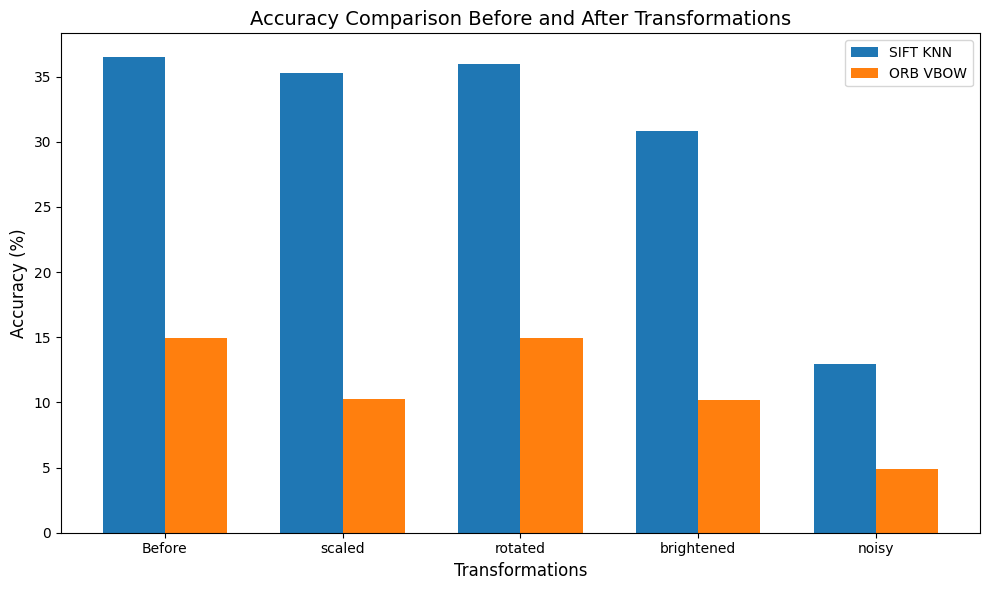

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data directly from transformed_accuracies dictionary
transformations = list(transformed_accuracies.keys())
sift_accuracies = [transformed_accuracies[trans]['sift'] for trans in transformations]
orb_accuracies = [transformed_accuracies[trans]['orb'] for trans in transformations]

# Add 'Before Transformations' results
methods = ['Before'] + transformations
sift_accuracies.insert(0, accuracy_score(test_labels, svm_sift_knn.predict(test_sift_feature_vectors)) * 100)
orb_accuracies.insert(0, accuracy_score(test_labels, svm_orb_vbow.predict(test_orb_vbow)) * 100)

# Bar positions and width
indices = np.arange(len(methods))
bar_width = 0.35

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(indices - bar_width / 2, sift_accuracies, bar_width, label='SIFT KNN')
plt.bar(indices + bar_width / 2, orb_accuracies, bar_width, label='ORB VBOW')

# Customize the chart
plt.xlabel('Transformations', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy Comparison Before and After Transformations', fontsize=14)
plt.xticks(indices, methods)
plt.legend()

# Display the chart
plt.tight_layout()
plt.show()


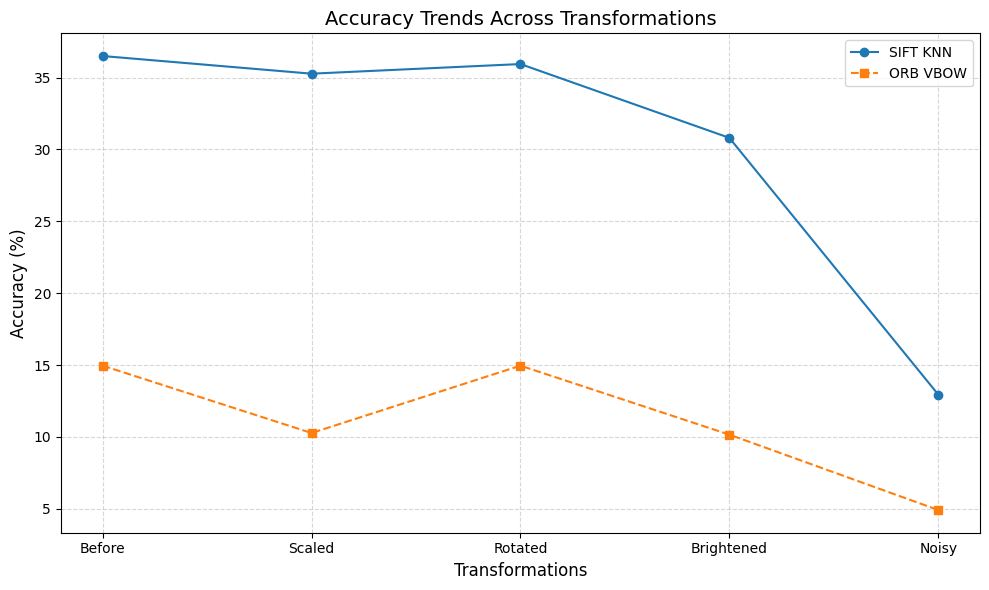

In [9]:
import matplotlib.pyplot as plt

# Assuming transformed_accuracies and pre-transformation accuracy results are available
methods = ['Before', 'Scaled', 'Rotated', 'Brightened', 'Noisy']

# Extract accuracies dynamically
sift_knn_accuracies = [
    accuracy_score(test_labels, svm_sift_knn.predict(test_sift_feature_vectors)) * 100
] + [transformed_accuracies[trans]['sift'] for trans in transformed_accuracies]

orb_vbow_accuracies = [
    accuracy_score(test_labels, svm_orb_vbow.predict(test_orb_vbow)) * 100
] + [transformed_accuracies[trans]['orb'] for trans in transformed_accuracies]

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(methods, sift_knn_accuracies, marker='o', label='SIFT KNN', linestyle='-')
plt.plot(methods, orb_vbow_accuracies, marker='s', label='ORB VBOW', linestyle='--')

# Adding labels and title
plt.xlabel('Transformations', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Accuracy Trends Across Transformations', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Display the chart
plt.tight_layout()
plt.show()
